In [14]:
import shap

In [15]:
# Initialise SHAP
explainer = shap.Explainer(best_models["xx"])
shap_values = explainer.shap_values(test_x)

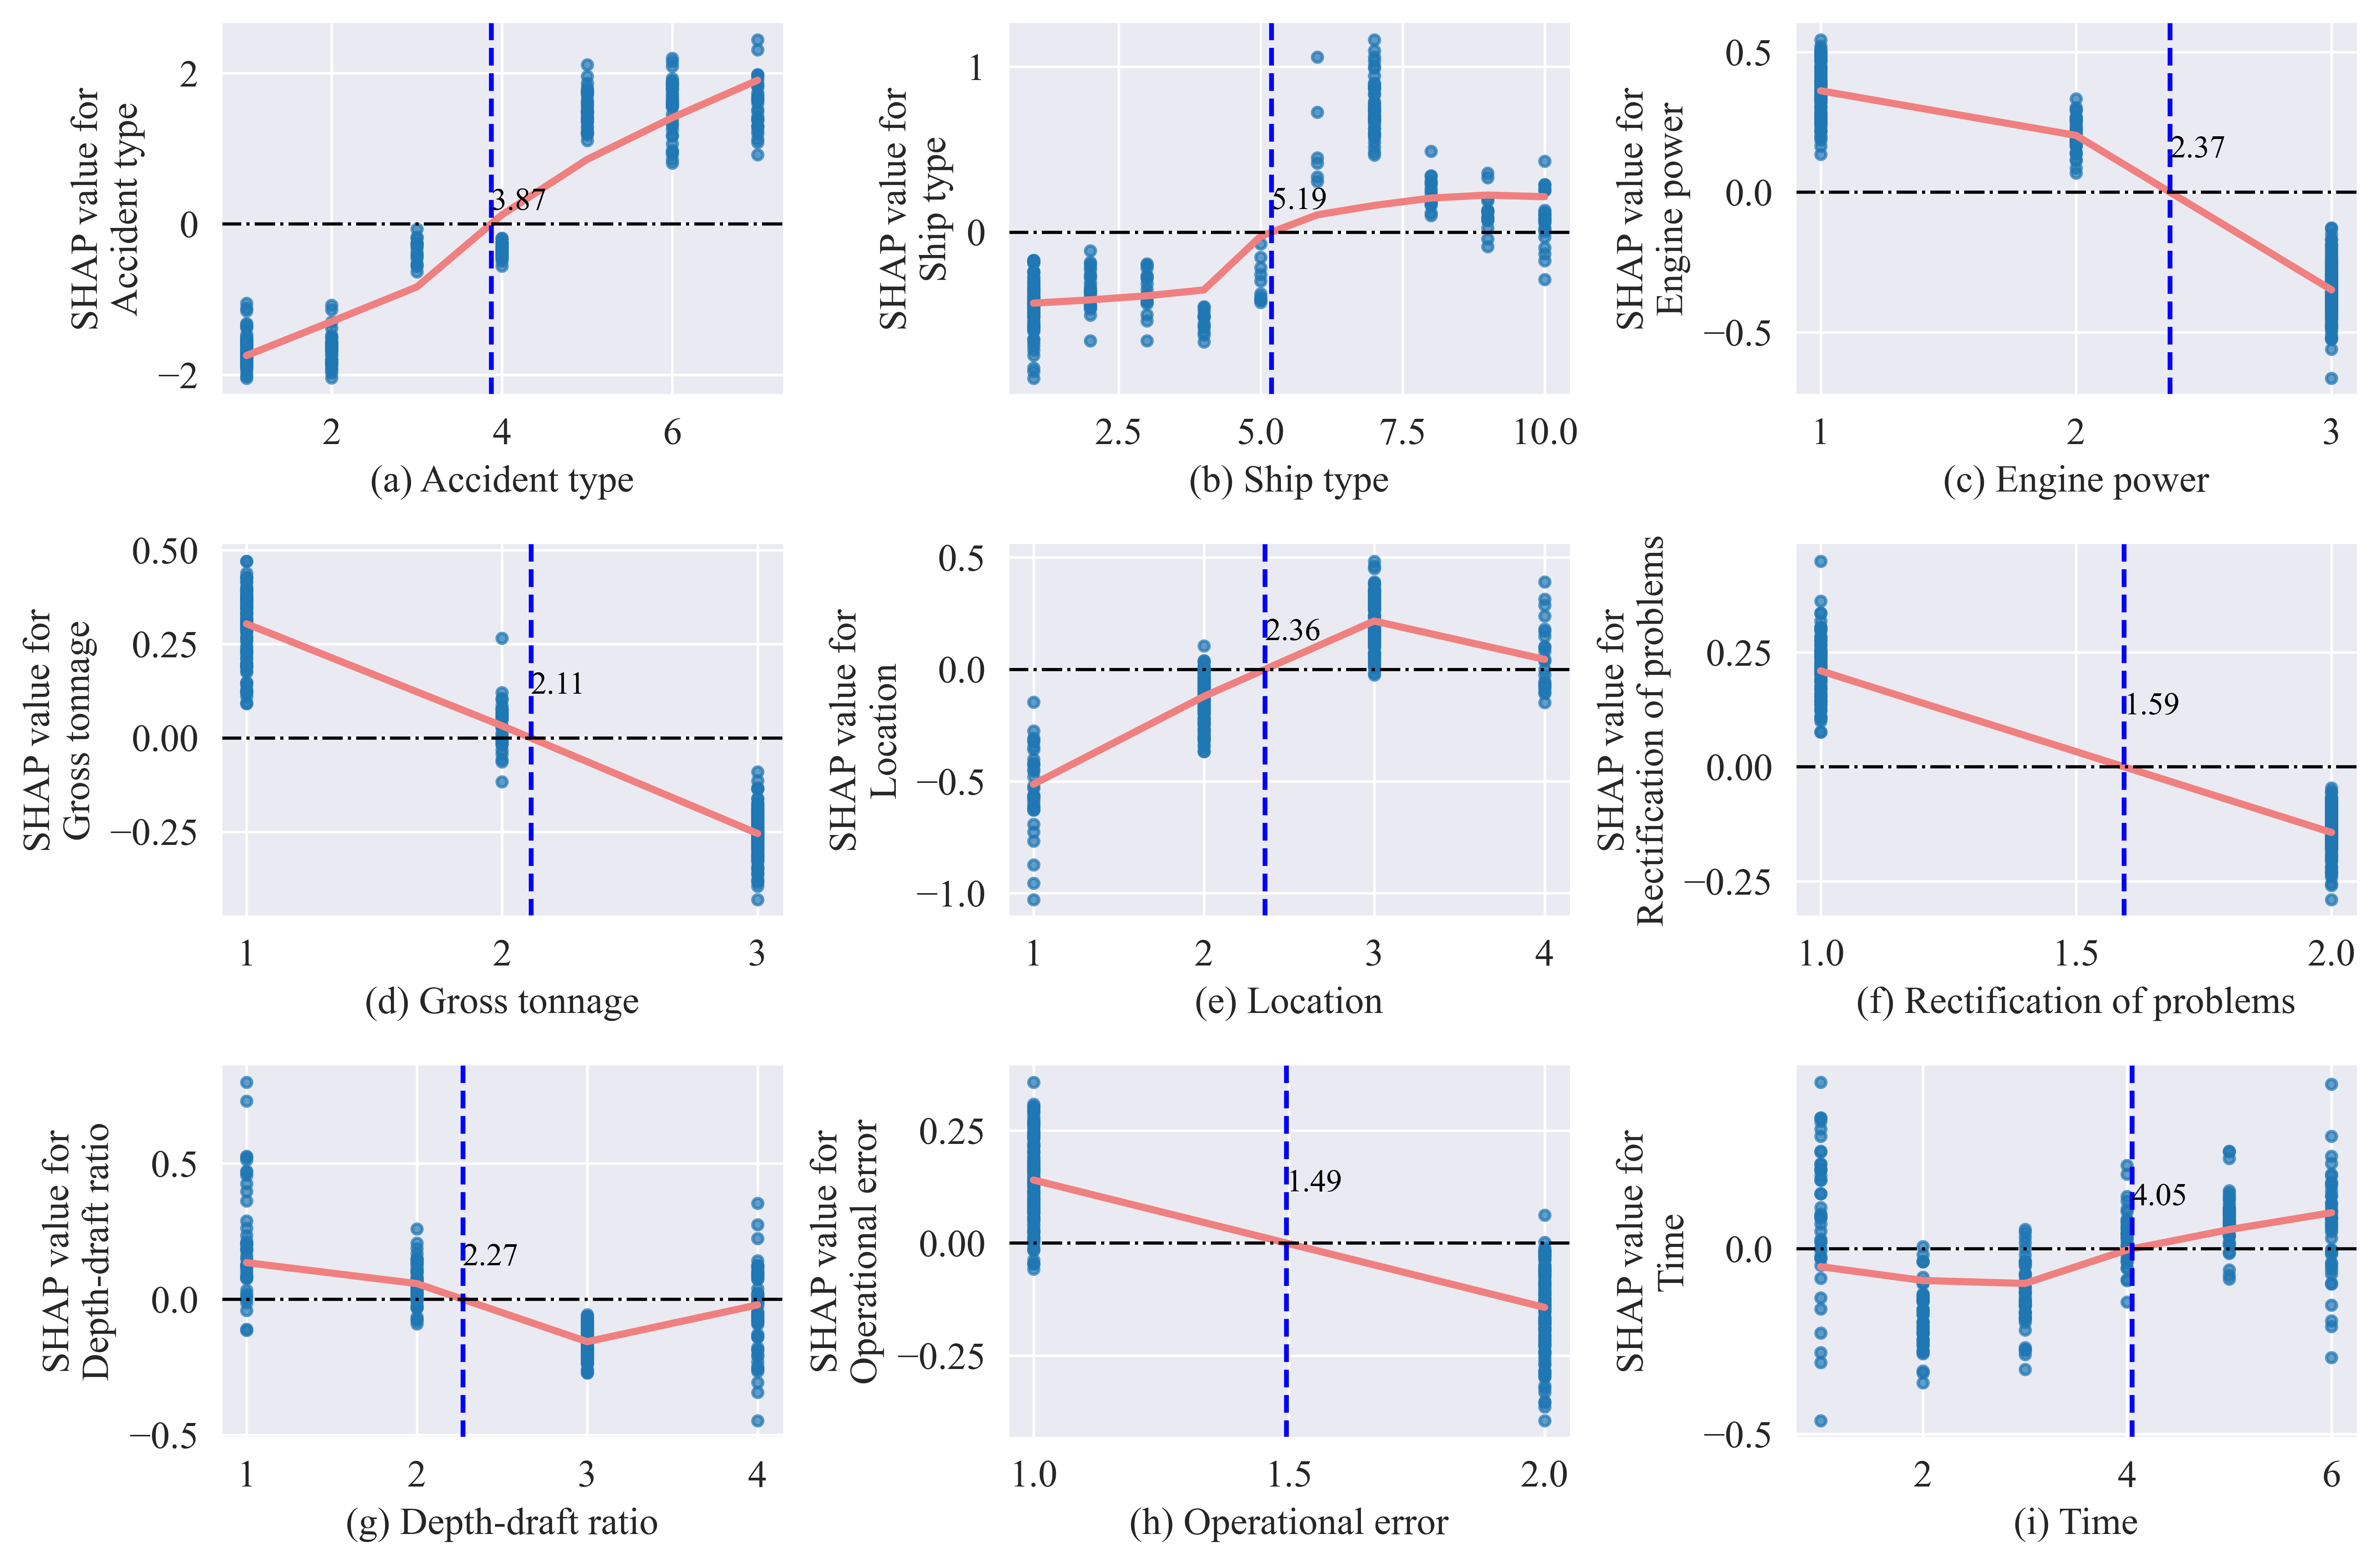

In [25]:
def plot_shap_dependence(feature_list, data, shap_values_data, file_name="SHAP_Dependence_Plots.png"):
    # Set Seaborn style to darkgrid
    sns.set_style("darkgrid")
    
    # Set font to Times New Roman, size 12
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 12

    # Dynamically adjust the number of subplot rows and columns based on feature count
    num_features = len(feature_list)
    rows = (num_features // 3) + (1 if num_features % 3 != 0 else 0)
    cols = 3

    fig, axs = plt.subplots(rows, cols, figsize=(12, 8), dpi=600)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Loop to plot SHAP dependence plots for each feature
    for i, feature in enumerate(feature_list):
        row = i // cols  # Row index
        col = i % cols   # Column index

        # If only one row, axs is a 1D array, needs special handling
        if rows == 1:
            ax = axs[col]
        else:
            ax = axs[row, col]

        # Scatter plot: x-axis is feature values, y-axis is SHAP values
        ax.scatter(data[feature], shap_values_data[feature], s=10, alpha=0.7)

        # Add LOWESS fitting curve
        lowess_data = sns.regplot(x=data[feature], y=shap_values_data[feature], scatter=False, lowess=True, color='lightcoral', ax=ax)
        line = lowess_data.get_lines()[0]  # Fitted line object
        x_fit = line.get_xdata()  # X data of LOWESS fitting line
        y_fit = line.get_ydata()  # Y data of LOWESS fitting line

        # Find all x values where the line crosses y=0
        x_intercepts = find_zero_crossings(x_fit, y_fit)

        # Mark all x_intercepts in the plot
        for x_intercept in x_intercepts:
            ax.axvline(x=x_intercept, color='blue', linestyle='--')  # Mark with dashed line
            ax.text(x_intercept, 0.1, f'{x_intercept:.2f}', color='black', fontsize=10, verticalalignment='bottom')

        # Add horizontal line at shap=0
        ax.axhline(y=0, color='black', linestyle='-.', linewidth=1)

        # Generate alphabetical labels (a), (b), (c)...
        label = f"({chr(97 + i)}) {feature}"

        # Set x and y axis labels, x-axis includes alphabetical label
        ax.set_xlabel(label, fontsize=12)
        ax.set_ylabel(f'SHAP value for\n{feature}', fontsize=12)

        # Hide top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Hide empty subplots if number of features < rows * cols
    if num_features < rows * cols:
        for i in range(num_features, rows * cols):
            fig.delaxes(axs.flat[i])

    # Save as PNG file, resolution 600 DPI
    plt.savefig(file_name, format='png', bbox_inches='tight', dpi=600)
    plt.show()

# Use the function to plot SHAP dependence plots for specific features
feature_list = ['Accident type', 'Ship type', 'Engine power', 'Gross tonnage', 'Location', 'Rectification of problems', 'Depth-draft ratio'
               , 'Operational error', 'Time']
plot_shap_dependence(feature_list, test_x, shap_values_df)

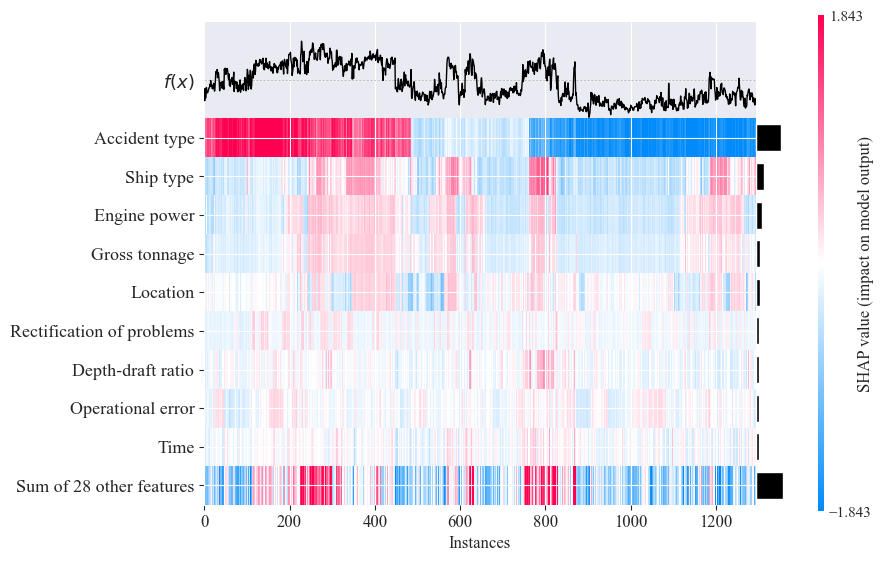

In [51]:
# # Create shap.Explanation object
# shap_explanation = shap.Explanation(
#     values=shap_values[0:500, :],             # First 500 rows of SHAP values
#     base_values=explainer.expected_value,      # Base values
#     data=test_x.iloc[0:500, :],               # Feature data
#     feature_names=test_x.columns               # Feature names
# )

# Create shap.Explanation object
shap_explanation = shap.Explanation(
    values=shap_values,             # SHAP values
    base_values=explainer.expected_value,      # Base values
    data=x.iloc,               # Feature data
    feature_names=x.columns               # Feature names
)

# Set global font to Times New Roman, size 12
plt.rc('font', family='Times New Roman', size=12)

# Plot heatmap
plt.figure(figsize=(10,5))
# shap.plots.heatmap(shap_explanation, cmap='plasma')
shap.plots.heatmap(shap_explanation)

# # Save heatmap as PNG format, resolution 600 DPI
# plt.savefig('heatmap.png', dpi=600, bbox_inches='tight')

# Show plot
plt.show()


In [35]:
# Set font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# Create SHAP summary plot
plt.figure(figsize=(10, 5), dpi=1200)

# Use an advanced color scheme (e.g., 'coolwarm' or 'viridis')
shap.summary_plot(shap_values, x, show=False, max_display=9, cmap='plasma')

# Add a title and place it below the chart
plt.figtext(0.5, -0.05, '(c) SHAP summary plot (Top 10 features)', ha='center', fontsize=12, fontfamily='Times New Roman')

# Adjust layout
plt.tight_layout()

# # Save as PNG file, resolution 600 DPI
# plt.savefig("summary_plot.png", format='png', dpi=600, bbox_inches='tight')

# Show plot
plt.show()


In [36]:
# Set font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# Set figure size and resolution
plt.figure(figsize=(10, 5), dpi=1200)

# Calculate mean absolute SHAP value for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
top_n = 9  # Number of features to display
top_indices = np.argsort(mean_shap_values)[-top_n:]  # Find indices of top features

# Sort from largest to smallest
sorted_indices = np.argsort(mean_shap_values[top_indices])[::-1]  # Reverse sort indices
sorted_shap_values = mean_shap_values[top_indices][sorted_indices]
sorted_feature_names = np.array(shap_values.feature_names)[top_indices][sorted_indices]

# Plot SHAP bar chart
colors = plt.cm.plasma(np.linspace(0, 1, top_n))  # Use 'plasma' colormap, suitable for publication
plt.barh(sorted_feature_names[::-1], sorted_shap_values[::-1], color=colors)  # Reverse Y-axis to place largest value on top

# Reset font and size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# # Add a title and place it below the chart
# plt.figtext(0.5, -0.05, '(b) SHAP Explanation: Sorted Feature Importance (Top 10 features)', ha='center', fontsize=12, fontfamily='Times New Roman')

# Set axis labels
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Adjust margins for better readability
plt.tight_layout()

# # Save as PNG file, resolution 600 DPI
# plt.savefig("feature_importance.png", format='png', dpi=600, bbox_inches='tight')

# Show figure
plt.show()

In [37]:
import os

In [40]:
import seaborn as sns

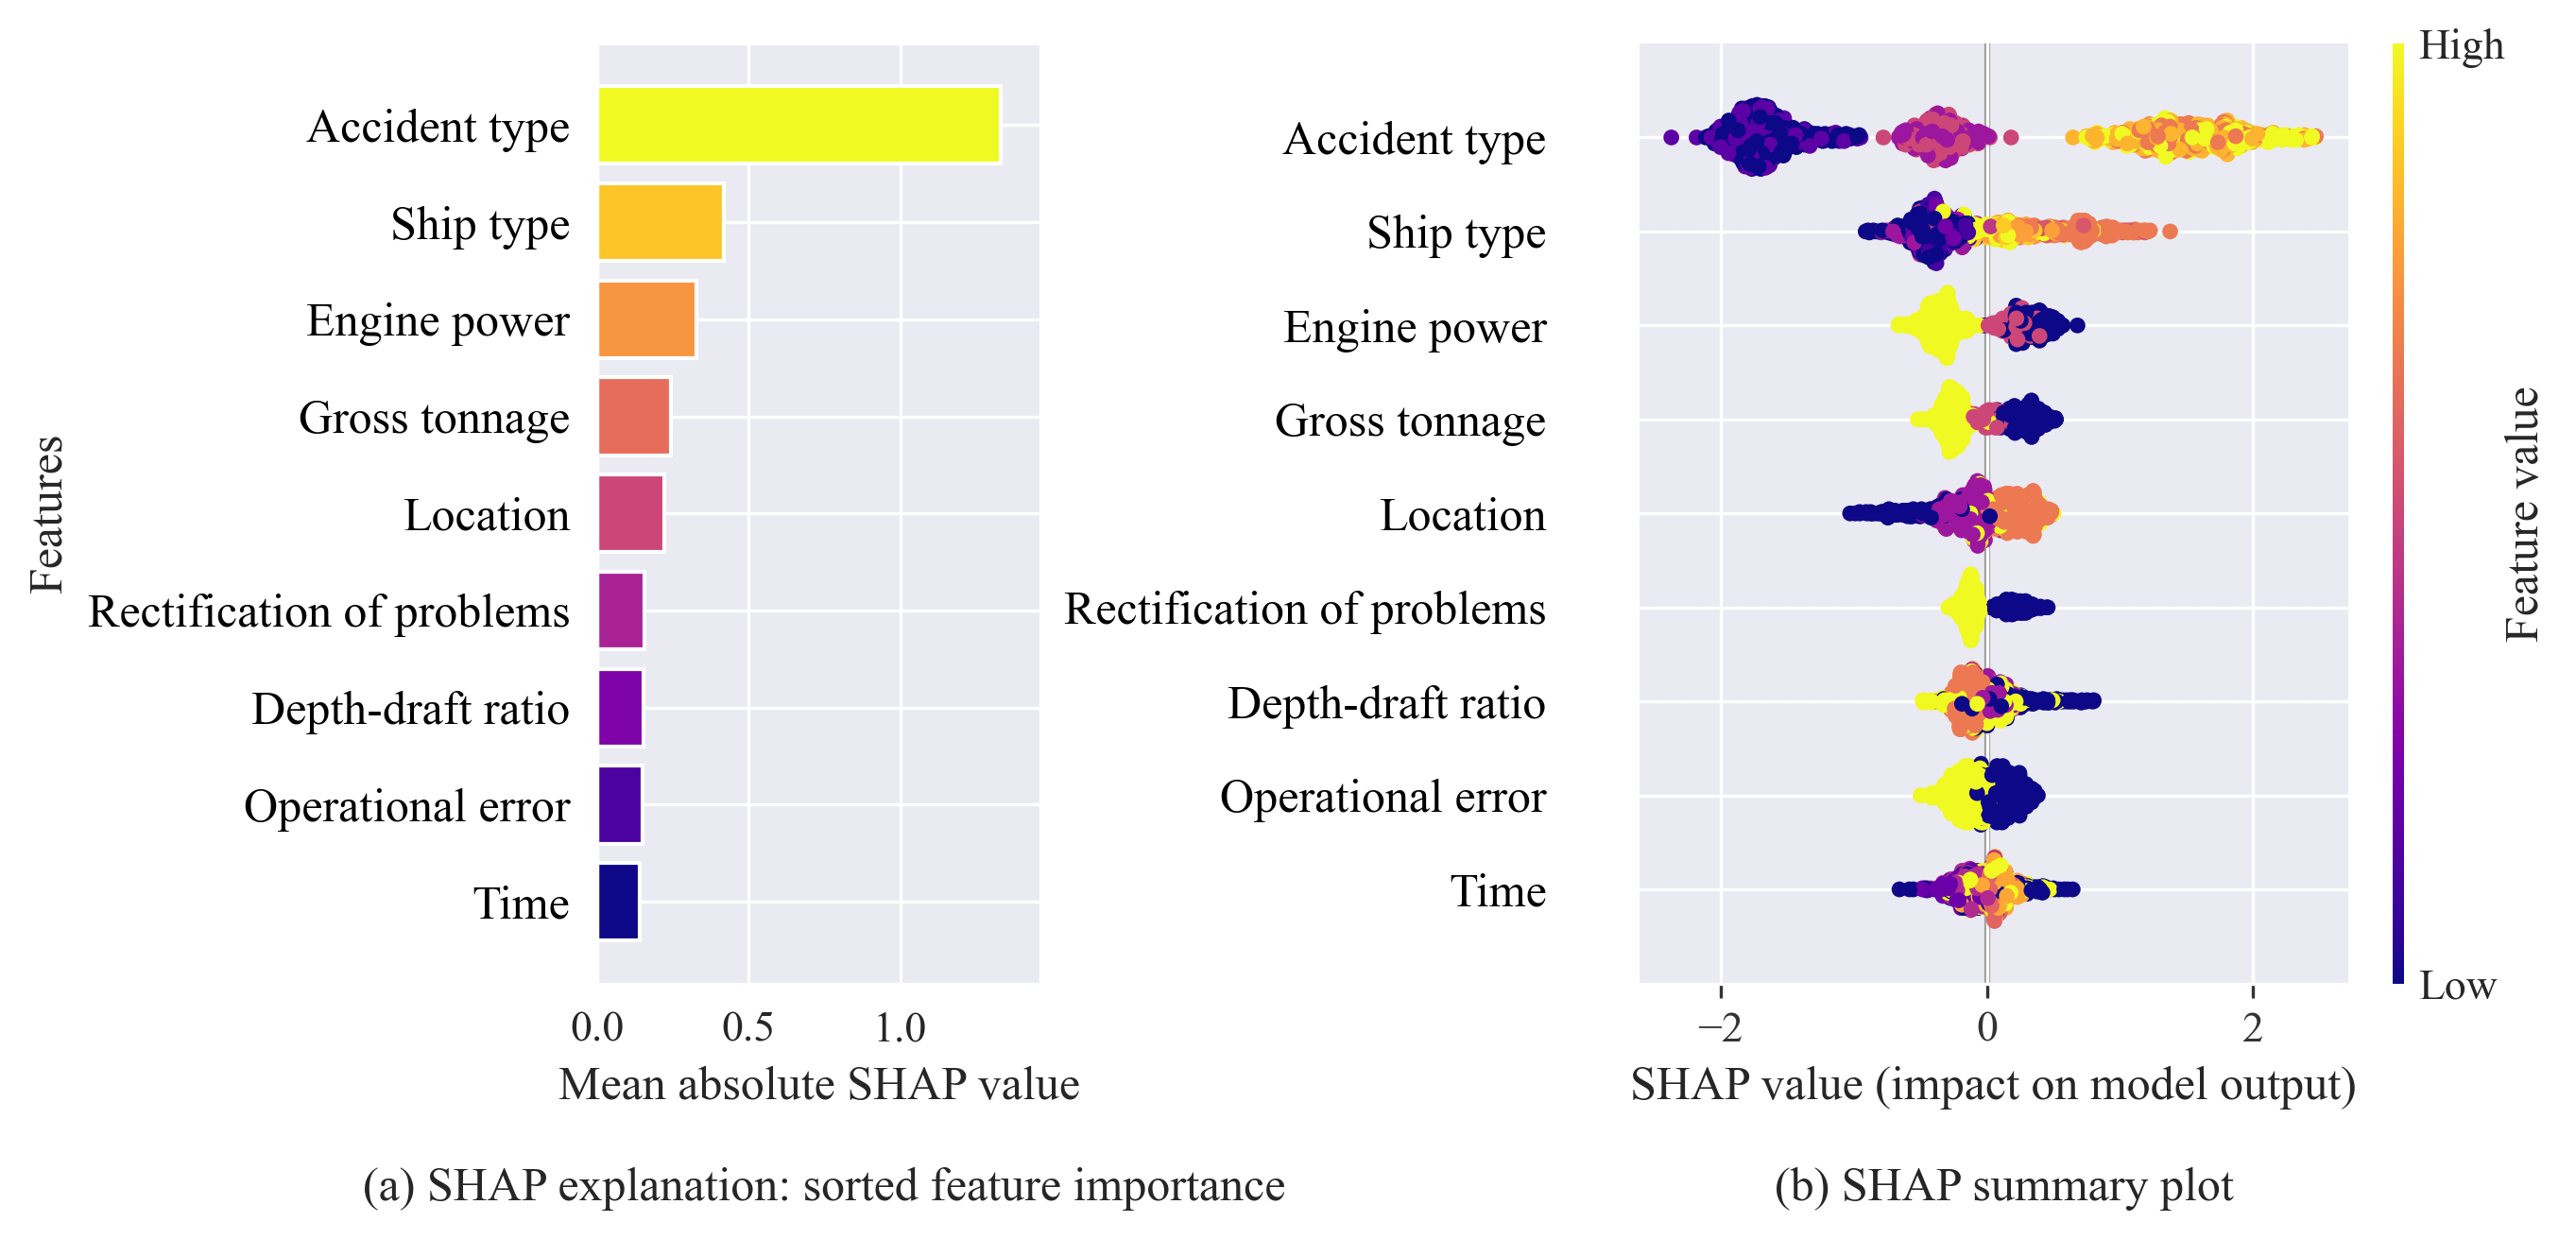

In [44]:
# Set Seaborn style
sns.set_style("darkgrid")

# Set font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=300, gridspec_kw={'width_ratios': [1, 2]})

# First plot: SHAP bar chart
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
top_n = 9  # Number of features to display
top_indices = np.argsort(mean_shap_values)[-top_n:]  # Get indices of the top features

# Sort from largest to smallest
sorted_indices = np.argsort(mean_shap_values[top_indices])[::-1]  # Reverse sort indices
sorted_shap_values = mean_shap_values[top_indices][sorted_indices]
sorted_feature_names = np.array(shap_values.feature_names)[top_indices][sorted_indices]

# Plot bar chart
colors = plt.cm.plasma(np.linspace(0, 1, top_n))[::-1]  # Use 'plasma' colormap and reverse order
axs[0].barh(sorted_feature_names, sorted_shap_values, color=colors)  # Keep y-axis order from largest to smallest
axs[0].set_xlabel('Mean absolute SHAP value', fontsize=12)  # Set x-axis label font size for the first plot
axs[0].set_ylabel('Features', fontsize=12)

# Set font size of x-axis tick labels in the first plot
axs[0].tick_params(axis='x', labelsize=11)

# Adjust layout of the bar chart subplot
axs[0].invert_yaxis()  # Ensure the largest value is on top
axs[0].set_xlim([0, sorted_shap_values.max() * 1.1])  # Add margin to the X-axis
axs[0].set_position([0.05, 0.2, 0.35, 0.7])  # Adjust the position of the first plot

# Set y-axis feature label colors
for label in axs[0].get_yticklabels():
    label.set_color('black')  # Set all labels to black

# Second plot: SHAP summary plot with 'plasma' colormap
plt.sca(axs[1])  # Switch to the second subplot
shap.summary_plot(shap_values, x, show=False, max_display=9, cmap='plasma')

# Set x-axis label for the second plot
axs[1].set_xlabel('SHAP value (impact on model output)', fontsize=12)  # Set x-axis label font size for the second plot

# Manually set y-axis label color and font for the second plot
axs[1].set_yticklabels([t.get_text() for t in axs[1].get_yticklabels()], color='black', fontsize=12)

# Adjust layout, increase spacing between subplots to reduce overlap
plt.subplots_adjust(wspace=0.9, left=0.1, right=0.95, top=0.85, bottom=0.2)

# Add titles below each subplot
fig.text(0.2, 0.05, '(a) SHAP explanation: sorted feature importance', ha='center', fontsize=12)
fig.text(0.72, 0.05, '(b) SHAP summary plot', ha='center', fontsize=12)

# Save as high-resolution image
plt.savefig("improved_shap_plot.png", format='png', dpi=600, bbox_inches='tight')

# Show figure
plt.show()

Sample Index: 811
Probability of Non-serious: 0.12
Probability of Serious: 0.88


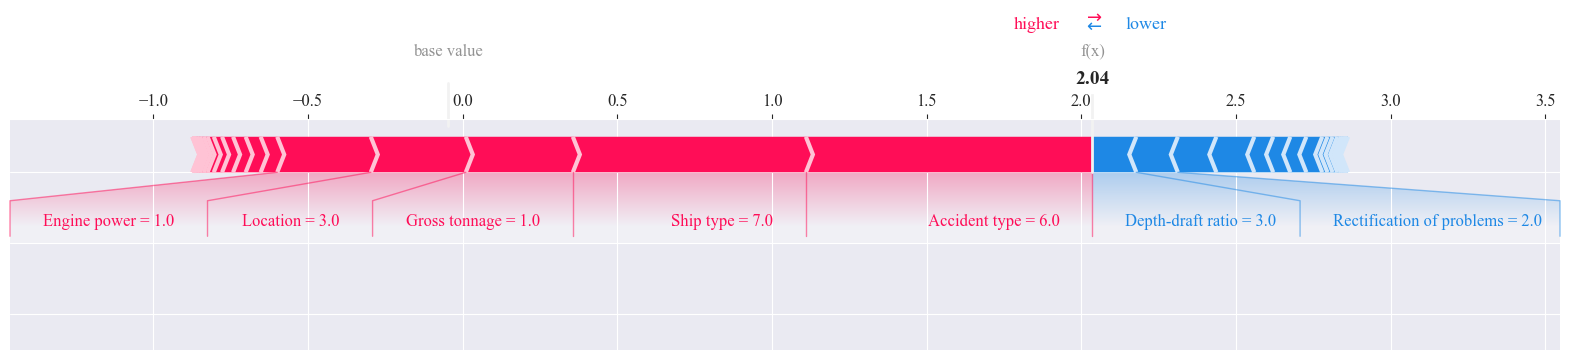

None

In [49]:
# Compute SHAP values
explainer = shap.Explainer(model)
shap_values_test = explainer(x)  # Changed test_x to x

# Round values in x to 2 decimal places
x_rounded = x.round(2)  # Changed test_x to x

# Select a sample index for explanation
sample_index = 811

# Get predicted probabilities
pred_probs = model.predict_proba(x)  # Get predicted probabilities

# Select the predicted probabilities for the chosen sample
prob_non_serious = pred_probs[sample_index, 0]  # Probability of class 0 (Non-serious)
prob_serious = pred_probs[sample_index, 1]      # Probability of class 1 (Serious)

# Print predicted probabilities
print(f"Sample Index: {sample_index}")
print(f"Probability of Non-serious: {prob_non_serious:.2f}")
print(f"Probability of Serious: {prob_serious:.2f}")

# Initialize SHAP visualization
shap.initjs()

# Plot SHAP explanation for a single sample (Force Plot)
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values_test[sample_index].values,  # Use computed SHAP values
    x_rounded.iloc[sample_index],  # Changed test_x_rounded to x_rounded
    matplotlib=True  # Set to True to generate a static figure
)

# Save the current figure as a PNG file
plt.savefig('force_plot_sample_811.png', dpi=600)  # Save as PNG format
plt.close()  # Close the figure to free memory

# Display the force plot using IPython.display
from IPython.display import display
display(force_plot)